This notebook generates the Pareto plots in the paper using the saved results obtained by running `run_get_results.sh`

In [9]:
import sys; sys.path.append("../") # For relative imports

import glob
import os
import pandas as pd
import pickle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from utils.conformal_utils import *
from utils.experiment_utils import get_inputs_folder, get_outputs_folder, get_figs_folder


%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 16,        # base font size
    'axes.titlesize': 18,   # subplot titles
    'axes.labelsize': 16,   # x/y labels
    'legend.fontsize': 16,  # legend text
    'xtick.labelsize': 16,  # tick labels
    'ytick.labelsize': 16,

})
# use tex with matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

dataset_names = {
    "plantnet": "Pl@ntNet-300K",
    "plantnet-trunc": "Pl@ntNet-300K (truncated)",
    "inaturalist": "iNaturalist",
    "inaturalist-trunc": "iNaturalist (truncated)",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load in paths from folders.json
inputs_folder = get_inputs_folder()
results_folder = get_outputs_folder()
fig_folder = get_figs_folder()

In [3]:
def compute_train_weighted_average_set_size(dataset, metrics, train_class_distr, test_labels):
    num_classes = np.max(test_labels) + 1
    
    # Get average set size by class
    set_sizes = metrics['coverage_metrics']['raw_set_sizes']
    avg_size_by_class = np.array([np.mean(set_sizes[test_labels == k]) for k in range(num_classes)])

    return np.sum(train_class_distr * avg_size_by_class)

def load_one_result(dataset, alpha, method_name, score='softmax',
                train_class_distr=None, test_labels=None):
    
    with open(f'{results_folder}/{dataset}_{score}_alpha={alpha}_{method_name}.pkl', 'rb') as f:
        metrics = pickle.load(f)

    # Compute train-weighted average set size
    # Compute average set size by class, then weight
    if (train_class_distr is not None) and (test_labels is not None):
        metrics['set_size_metrics']['train_mean'] = compute_train_weighted_average_set_size(dataset, 
                                                                                            metrics, 
                                                                                            train_class_distr, 
                                                                                            test_labels)
    
    return metrics

def load_all_results(dataset, alphas, methods, score='softmax'):
    # For truncated datasets, we need to load these in to compute train-weighted average set size
    if dataset.endswith('-trunc'): 
        train_labels_path = f'{inputs_folder}/{dataset}_train_labels.npy'
        train_labels = np.load(train_labels_path)
        num_classes = np.max(train_labels) + 1
        train_class_distr = np.array([np.sum(train_labels == k) for k in range(num_classes)]) / len(train_labels) 

        test_labels = test_labels = np.load(f'{inputs_folder}/best-{dataset}-model_test_labels.npy')
        
    all_res = {}
    for alpha in alphas:
        res = {}
        for method in methods:
            if dataset.endswith('-trunc'): # Compute train-weighted average set size
                res[method] = load_one_result(dataset, alpha, method, score=score,
                                           train_class_distr=train_class_distr, test_labels=test_labels)
            else:
                res[method] = load_one_result(dataset, alpha, method, score=score)
        all_res[f'alpha={alpha}'] = res

    return all_res

def plot_set_size_vs_cov_metric(
    all_res,
    coverage_metric,
    alphas=None,
    set_size_metric='mean',
    ax=None,
    show_legend=True,
    markersizes=None,
    label_prefix='',
    add_inset=True,
    inset_loc='upper right',
    inset_lims=(0.1, 0.3, 1, 15),
    inset_width="50%",
    inset_pad=0
):
    # --- prepare main axis ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.9, 2.3))

    # --- determine alphas ---
    if alphas is None:
        alphas = sorted(
            float(k.split('=')[1]) for k in all_res if k.startswith('alpha=')
        )

    # --- markersizes ---
    n = len(alphas)
    if markersizes is None:
        markersizes = np.linspace(7, 3, n)

    # --- fixed definitions ---
    cw_weights = 1 - np.array([0, .001, .01, .025, .05, .1, .15, .2, .4, .6, .8, 1])
    rarity_bandwidths = [1e-30, 1e-15, 1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 10, 1000]
    random_bandwidths = [1e-30, 1e-15, 1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 10, 1000]
    quantile_bandwidths = [1e-30, 1e-15, 1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 10, 1000]
    core_methods = [
        ('standard',             'Standard',       'blue',      'X'),
        ('classwise',            'Classwise',      'red',       'X'),
        ('classwise-exact',      'Exact Classwise','magenta',  'x'),
        ('clustered',            'Clustered',      'limegreen', 'x'),
        ('prevalence-adjusted',  'Standard w. PAS','green',    '^'),
        ('standard-softmax',     'Standard w. softmax', 'blue',  'x'),
    ]

    # --- plot main curves ---
    for alpha, ms in zip(alphas, markersizes):
        res = all_res.get(f'alpha={alpha}', {})
        suffix = f'{label_prefix}, $\\alpha={alpha}$'

        # core scatter methods (only if present)
        for key, label, color, mk in core_methods:
            if key in res:
                ax.plot(
                    res[key]['coverage_metrics'][coverage_metric],
                    res[key]['set_size_metrics'][set_size_metric],
                    linestyle='', marker=mk, color=color,
                    markersize=ms, alpha=0.8,
                    label=(label + suffix),
                    zorder=10
                )

        # convex interpolation (only weights that exist)
        valid_w = [w for w in cw_weights if f'cvx-cw_weight={w}' in res]
        if valid_w:
            x_cvx = [res[f'cvx-cw_weight={w}']['coverage_metrics'][coverage_metric] for w in valid_w]
            y_cvx = [res[f'cvx-cw_weight={w}']['set_size_metrics'][set_size_metric]     for w in valid_w]
            ax.plot(
                x_cvx, y_cvx,
                '-o', color='dodgerblue', markersize=ms,
                alpha=0.5,
                label=('Interp-Q' + suffix)
            )

        # fuzzy rarity projection 
        for tag, mk_sym, alpha_val, label in [
            ## Uncomment to use short name for Fuzzy
            ('fuzzy-rarity',   'o', 0.3, 'Raw Fuzzy'),
            ('fuzzy-RErarity', '^', 0.5, 'Fuzzy'),
            # # Uncomment to use long name for Fuzzy
            # ('fuzzy-rarity',   'o', 0.3, 'Raw Fuzzy-$\\Pi_{\\mathrm{prevalence}}$'),
            # ('fuzzy-RErarity', '^', 0.5, 'Fuzzy-$\\Pi_{\\mathrm{prevalence}}$'),
        ]:
            valid_b = [b for b in rarity_bandwidths if f'{tag}-{b}' in res]
            if valid_b:
                xs = [res[f'{tag}-{b}']['coverage_metrics'][coverage_metric] for b in valid_b]
                ys = [res[f'{tag}-{b}']['set_size_metrics'][set_size_metric]    for b in valid_b]
                ax.plot(
                    xs, ys,
                    '-' + mk_sym, color='salmon', markersize=ms,
                    alpha=alpha_val,
                    label=(label + suffix)
                )

        # fuzzy random projection 
        for tag, mk_sym, alpha_val, label in [
            ('fuzzy-random',   'o', 0.3, 'Raw Fuzzy-$\\Pi_{\\mathrm{random}}$'),
            ('fuzzy-RErandom', '^', 0.5, 'Fuzzy-$\\Pi_{\\mathrm{random}}$'),
        ]:
            valid_b = [b for b in rarity_bandwidths if f'{tag}-{b}' in res]
            if valid_b:
                xs = [res[f'{tag}-{b}']['coverage_metrics'][coverage_metric] for b in valid_b]
                ys = [res[f'{tag}-{b}']['set_size_metrics'][set_size_metric]    for b in valid_b]
                ax.plot(
                    xs, ys,
                    '-' + mk_sym, color='tab:purple', markersize=ms,
                    alpha=alpha_val,
                    label=(label + suffix)
                )
                
        # fuzzy quantile projection 
        for tag, mk_sym, alpha_val, label in [
            ('fuzzy-quantile',   'o', 0.3, 'Raw Fuzzy-$\\Pi_{\\mathrm{quantile}}$'),
            ('fuzzy-REquantile', '^', 0.5, 'Fuzzy-$\\Pi_{\\mathrm{quantile}}$'),
        ]:
            valid_b = [b for b in rarity_bandwidths if f'{tag}-{b}' in res]
            if valid_b:
                xs = [res[f'{tag}-{b}']['coverage_metrics'][coverage_metric] for b in valid_b]
                ys = [res[f'{tag}-{b}']['set_size_metrics'][set_size_metric]    for b in valid_b]
                ax.plot(
                    xs, ys,
                    '-' + mk_sym, color='gold', markersize=ms,
                    alpha=alpha_val,
                    label=(label + suffix)
                )


    # --- style main axis ---
    ax.set_yscale('log')
    ax.spines[['right', 'top']].set_visible(False)

    # --- inset ---
    if add_inset:
        xmin, xmax, ymin, ymax = inset_lims
        axins = inset_axes(
            ax, width=inset_width, height="40%", loc=inset_loc, borderpad=inset_pad
        )
        axins.patch.set_alpha(0.7)

        # replot all alphas for all methods, with the same presence checks
        for alpha, ms in zip(alphas, 0.5 * np.array(markersizes)):
            res = all_res.get(f'alpha={alpha}', {})

            # core
            for key, _, color, mk in core_methods:
                if key in res:
                    axins.plot(
                        res[key]['coverage_metrics'][coverage_metric],
                        res[key]['set_size_metrics'][set_size_metric],
                        linestyle='', marker=mk, color=color,
                        markersize=ms, alpha=0.8, zorder=10
                    )

            # convex
            valid_w = [w for w in cw_weights if f'cvx-cw_weight={w}' in res]
            if valid_w:
                axins.plot(
                    [res[f'cvx-cw_weight={w}']['coverage_metrics'][coverage_metric] for w in valid_w],
                    [res[f'cvx-cw_weight={w}']['set_size_metrics'][set_size_metric]    for w in valid_w],
                    '-o', color='dodgerblue', markersize=ms, alpha=0.5
                )

            # fuzzy
            for tag, mk_sym, alpha_val in [('fuzzy-rarity','o',0.3),('fuzzy-RErarity','^',0.5)]:
                valid_b = [b for b in rarity_bandwidths if f'{tag}-{b}' in res]
                if valid_b:
                    axins.plot(
                        [res[f'{tag}-{b}']['coverage_metrics'][coverage_metric] for b in valid_b],
                        [res[f'{tag}-{b}']['set_size_metrics'][set_size_metric]    for b in valid_b],
                        '-' + mk_sym, color='salmon', markersize=ms, alpha=alpha_val
                    )

        # zoom & ticks
        axins.set_xlim(xmin, xmax)
        axins.set_ylim(ymin, ymax)
        yticks = np.arange(int(np.ceil(ymin)), int(ymax) + 1)
        axins.set_yticks(yticks)
        axins.set_yticklabels([str(int(y)) if (int(y) % 2 == 0) else '' for y in yticks])
        for spine in axins.spines.values():
            spine.set_edgecolor('grey')
        axins.tick_params(axis='both', colors='grey', labelsize=8, pad=1)

        if inset_loc == 'upper left':
            mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec=(0.1,0.1,0.1,0.2))
        else:
            mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec=(0.1,0.1,0.1,0.2))

    # --- legend & layout ---
    if show_legend:
        ax.legend(fontsize=6, bbox_to_anchor=(1, 1))
    plt.tight_layout(pad=1.3)

# Specify where to zoom in 
def get_inset_lims(dataset, coverage_metric):
    xlims = {'plantnet': {'cov_below50': (0.1, 0.3), 
                          'undercov_gap': (0.1, 0.38),
                          'macro_cov': (0.6, 0.9)},
             'plantnet-trunc': {'cov_below50': (0.01, 0.17), 
                                'undercov_gap': (0.02, 0.2),
                                'macro_cov': (0.77, 0.87)},
             'inaturalist': {'cov_below50': (0.025, 0.16), 
                            'undercov_gap': (0.05, 0.175),
                            'macro_cov': (0.71, 0.9)},
             'inaturalist-trunc': {'cov_below50': (0.01, 0.07), 
                                   'undercov_gap': (0.03, 0.11),
                                   'macro_cov': (0.75, 0.92)}
            }
    ylims = {'plantnet': (0.9, 8), 
             'plantnet-trunc': (0.9, 5),
             'inaturalist': (2, 15),
             'inaturalist-trunc': (1.1, 13)}

    return *xlims[dataset][coverage_metric], *ylims[dataset]


def generate_all_pareto_plots(dataset, score, alphas, methods, 
                              save_suffix='', show_inset=None, legendfontsize=14):
    
    # Load pre-computed metrics
    all_res = load_all_results(dataset, alphas, methods, score=score)

    if score == 'PAS':
        std_with_softmax = load_all_results(dataset, alphas, ['standard'], score='softmax')
        for alpha in alphas:
            all_res[f'{alpha=}']['standard-softmax'] = std_with_softmax[f'{alpha=}']['standard']

    # Make plots
    set_size_metric = 'train_mean' if dataset.endswith('-trunc') else 'mean'
    print(f'{set_size_metric=}')

    cov_metrics = ['cov_below50', 'undercov_gap', 'macro_cov',
               'train_marginal_cov']
    cov_metric_names = ['FracBelow50$\\%$', 
                       'UnderCovGap',
                        'MacroCov',
                       'MarginalCov']
    fig, axes = plt.subplots(1, len(cov_metrics), figsize=(13, 3), sharey=True)
    axes = axes.flatten()

    for i, (coverage_metric, xlabel) in enumerate(zip(cov_metrics, cov_metric_names)):
        ax = axes[i]

        if (not show_inset) or (coverage_metric == 'train_marginal_cov') or (score == 'PAS'):
            add_inset = False
        else:
            add_inset = True 
   
        if add_inset:
            inset_lims = get_inset_lims(dataset, coverage_metric)
        else:
            inset_lims = None
    
        if coverage_metric == 'macro_cov':
            inset_loc = 'upper left'
            inset_pad = 1
        else:
            inset_loc = 'upper right'
            inset_pad = 1
    
        if coverage_metric == 'train_marginal_cov':
            for a in alphas:
                ax.axvline(1-a, linestyle='--', color='grey')
                
        plot_set_size_vs_cov_metric(
            all_res,
            coverage_metric=coverage_metric,
            set_size_metric=set_size_metric,
            alphas=alphas,
            ax=ax,
            add_inset=add_inset,
            inset_loc=inset_loc,
            inset_lims=inset_lims,
            inset_width="50%",
            inset_pad=inset_pad,
            show_legend=False
        )
        
        ax.set_xlabel(xlabel)
    
    axes[0].set_ylabel('Average set size')
    plt.suptitle(dataset_names[dataset], y=1)
    
    fig_path = f'{fig_folder}/{dataset}/ALL_metrics_{dataset}_{score}{save_suffix}_pareto_NO_LEGEND.pdf'
    os.makedirs(f'{fig_folder}/{dataset}', exist_ok=True)
    
    # Save version without legend
    plt.savefig(fig_path)
    
    # # Save version with legend
    axes[0].legend(ncols = len(alphas), loc='upper left', bbox_to_anchor=(-0.25,-0.35), fontsize=legendfontsize)
    plt.savefig(fig_path.replace('NO_LEGEND.pdf', 'WITH_LEGEND.pdf'), bbox_inches='tight')
    plt.savefig(fig_path.replace('NO_LEGEND.pdf', 'WITH_LEGEND.jpg'), bbox_inches='tight') # Also save as jpg
    
    print('Saved no-legend version to', fig_path, 'and version with legend to [...]WITH_LEGEND.pdf and .jpg' )
    
    plt.show()

        

## Figure 3 plots

set_size_metric='mean'
Saved no-legend version to figs/plantnet/ALL_metrics_plantnet_softmax_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


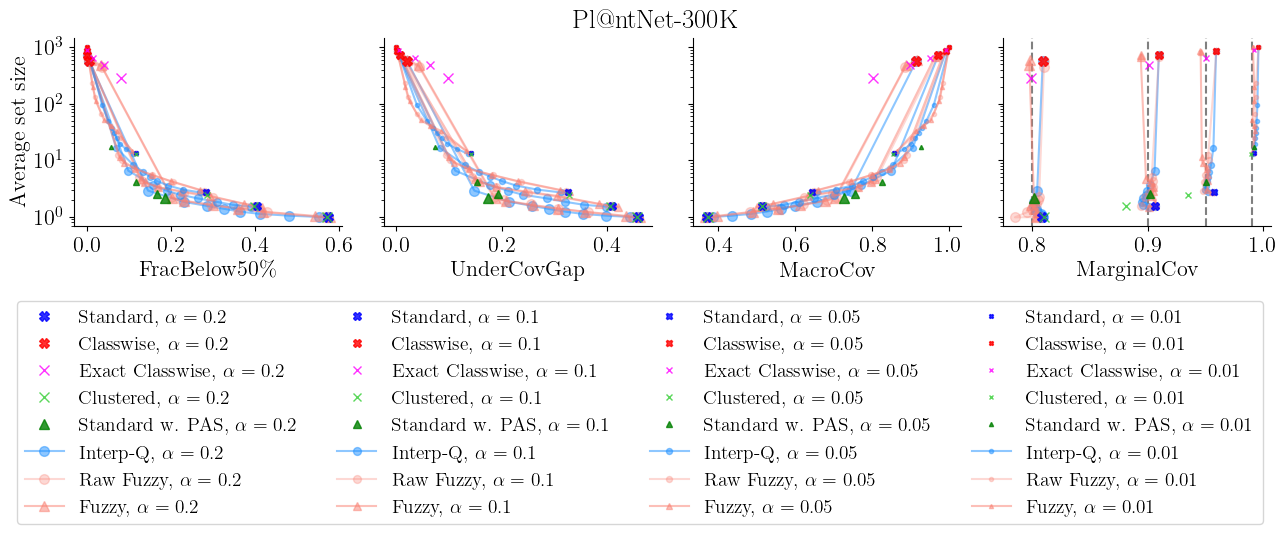

set_size_metric='train_mean'
Saved no-legend version to figs/plantnet-trunc/ALL_metrics_plantnet-trunc_softmax_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


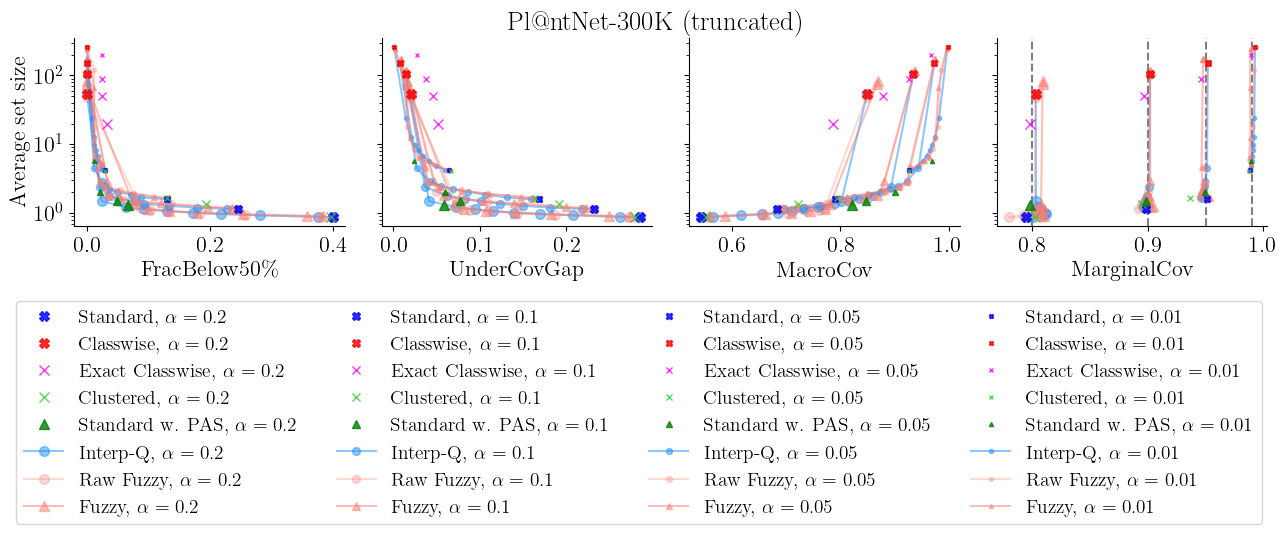

set_size_metric='mean'
Saved no-legend version to figs/inaturalist/ALL_metrics_inaturalist_softmax_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


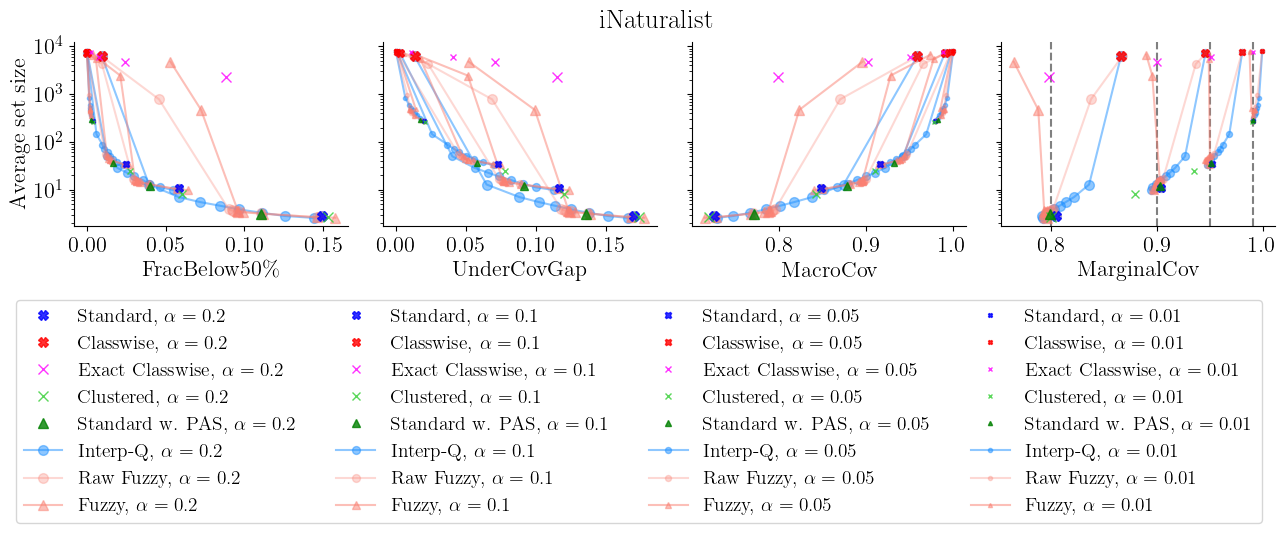

set_size_metric='train_mean'
Saved no-legend version to figs/inaturalist-trunc/ALL_metrics_inaturalist-trunc_softmax_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


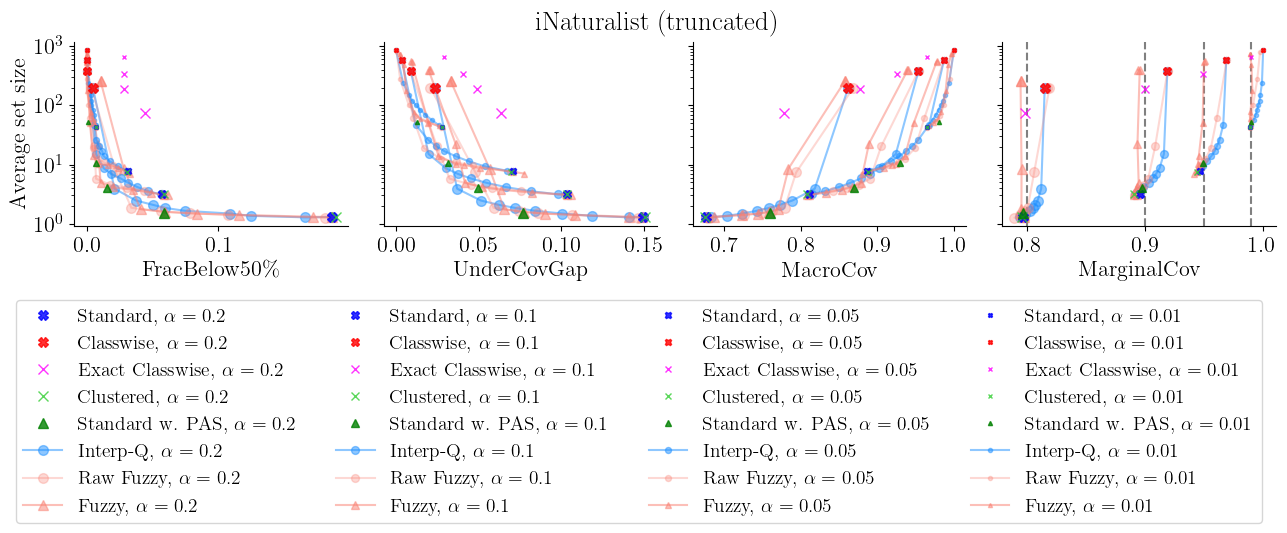

In [16]:
alphas = [0.2, 0.1, 0.05, 0.01]
score = 'softmax'

rarity_bandwidths = [1e-15, 1e-10, 1e-5, 0.0001, 0.001, 0.01, .1 , 10, 1000]
cw_weights = 1 - np.array([0, .001, .01, .025, .05, .1, .2, .4, .8, 1])
methods = ['standard', 'classwise', 'classwise-exact', 'clustered', 'prevalence-adjusted'] + \
            [f'fuzzy-rarity-{bw}' for bw in rarity_bandwidths] +\
            [f'fuzzy-RErarity-{bw}' for bw in rarity_bandwidths] +\
            [f'cvx-cw_weight={w}' for w in cw_weights] 

for dataset in dataset_names.keys():
    generate_all_pareto_plots(dataset, score, alphas, methods)

## Generate csv's of metrics

In [29]:
# Extract metrics into csv

def extract_metric_table(all_res, coverage_metrics, set_size_metric='mean'):
    records = []
    for alpha_key, methods in all_res.items():
        alpha_val = float(alpha_key.split('=')[1])
        for method, result in methods.items():
            row = {'alpha': alpha_val, 'method': method}
            for cov_metric in coverage_metrics:
                cov_val = result['coverage_metrics'].get(cov_metric, None)
                row[f'{cov_metric}'] = cov_val
            size_val = result['set_size_metrics'].get(set_size_metric, None)
            row[f'set_size_{set_size_metric}'] = size_val
            records.append(row)
    return pd.DataFrame(records)


score = 'softmax'
alphas = [0.2, 0.1, 0.05, 0.01]

for dataset in dataset_names.keys():
    set_size_metric = 'train_mean' if dataset.endswith('-trunc') else 'mean'
    
    # Load the results
    all_res = load_all_results(dataset, alphas, methods, score=score)
    
    # Extract into DataFrame
    df = extract_metric_table(
        all_res,
        coverage_metrics=['cov_below50', 'undercov_gap', 'macro_cov', 'train_marginal_cov'],
        set_size_metric=set_size_metric
    )
    
    # Save full CSV
    pth = f'{fig_folder}/{dataset}/{dataset}_{score}_metrics.csv'
    df.to_csv(pth, index=False)
    print(f'Saved csv of metrics to {pth}')

    ## --- Clean csv and save that ---
    selected_alpha = 0.1
    selected_methods = {'standard': 'Standard',
                       'classwise': 'Classwise',
                       'clustered': 'Clustered',
                       'prevalence-adjusted': 'Standard w. PAS',
                       'cvx-cw_weight=0.999': 'Interp-Q ($\\tau=0.999$)',
                       'cvx-cw_weight=0.99': 'Interp-Q ($\\tau=0.99$)',
                       'cvx-cw_weight=0.9': 'Interp-Q ($\\tau=0.9$)',
                       'fuzzy-rarity-1e-05': 'Raw Fuzzy ($\\sigma=0.00001$)',
                       'fuzzy-rarity-0.01': 'Raw Fuzzy ($\\sigma=0.01$)',
                       'fuzzy-rarity-0.1': 'Raw Fuzzy ($\\sigma=0.1$)',
                       'fuzzy-RErarity-1e-05': 'Fuzzy ($\\sigma=0.00001$)',
                       'fuzzy-RErarity-0.01': 'Fuzzy ($\\sigma=0.01$)',
                       'fuzzy-RErarity-0.1': 'Fuzzy ($\\sigma=0.1$)'}
    # Filter and rename methods
    df = df[df['alpha'] == selected_alpha] # Select alpha = 0.1 only
    df = df[df["method"].isin(selected_methods.keys())].copy()
    df["method"] = df["method"].map(selected_methods)

    # Remove alpha column
    df = df.drop('alpha', axis=1)

    # Rename columns
    df.rename(columns={'method': 'Method', 
                       'cov_below50': 'FracBelow50% $\\downarrow$',
                       'undercov_gap': 'UnderCovGap $\\downarrow$', 
                       'macro_cov': 'MacroCov $\\uparrow$',
                       'train_marginal_cov': 'MarginalCov (desired = 0.9)', 
                       'set_size_train_mean': 'Avg. set size $\\downarrow$',
                       'set_size_mean': 'Avg. set size'}, inplace=True)

    
    # Round numeric values to 3 significant digits
    def round_sig(x, sig=3):
        if isinstance(x, (int, float, np.float64)):
            return float(f"{x:.{sig}g}")
        return x
    df = df.map(round_sig)

    # Save
    pth = f'{fig_folder}/{dataset}/{dataset}_{score}_alpha={selected_alpha}_metrics_CLEANED.csv'
    df.to_csv(pth, index=False)
    print(f'Saved cleaned csv of metrics for alpha={selected_alpha} to {pth}')


Saved csv of metrics to figs/plantnet/plantnet_softmax_metrics.csv
Saved cleaned csv of metrics for alpha=0.1 to figs/plantnet/plantnet_softmax_alpha=0.1_metrics_CLEANED.csv
Saved csv of metrics to figs/plantnet-trunc/plantnet-trunc_softmax_metrics.csv
Saved cleaned csv of metrics for alpha=0.1 to figs/plantnet-trunc/plantnet-trunc_softmax_alpha=0.1_metrics_CLEANED.csv
Saved csv of metrics to figs/inaturalist/inaturalist_softmax_metrics.csv
Saved cleaned csv of metrics for alpha=0.1 to figs/inaturalist/inaturalist_softmax_alpha=0.1_metrics_CLEANED.csv
Saved csv of metrics to figs/inaturalist-trunc/inaturalist-trunc_softmax_metrics.csv
Saved cleaned csv of metrics for alpha=0.1 to figs/inaturalist-trunc/inaturalist-trunc_softmax_alpha=0.1_metrics_CLEANED.csv


In [24]:
df.columns

Index(['method', 'cov_below50', 'undercov_gap', 'macro_cov',
       'train_marginal_cov', 'set_size_train_mean'],
      dtype='object')

## Appendix plots

### Fuzzy and Interp-Q with PAS

set_size_metric='mean'
Saved no-legend version to figs/plantnet/ALL_metrics_plantnet_PAS_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


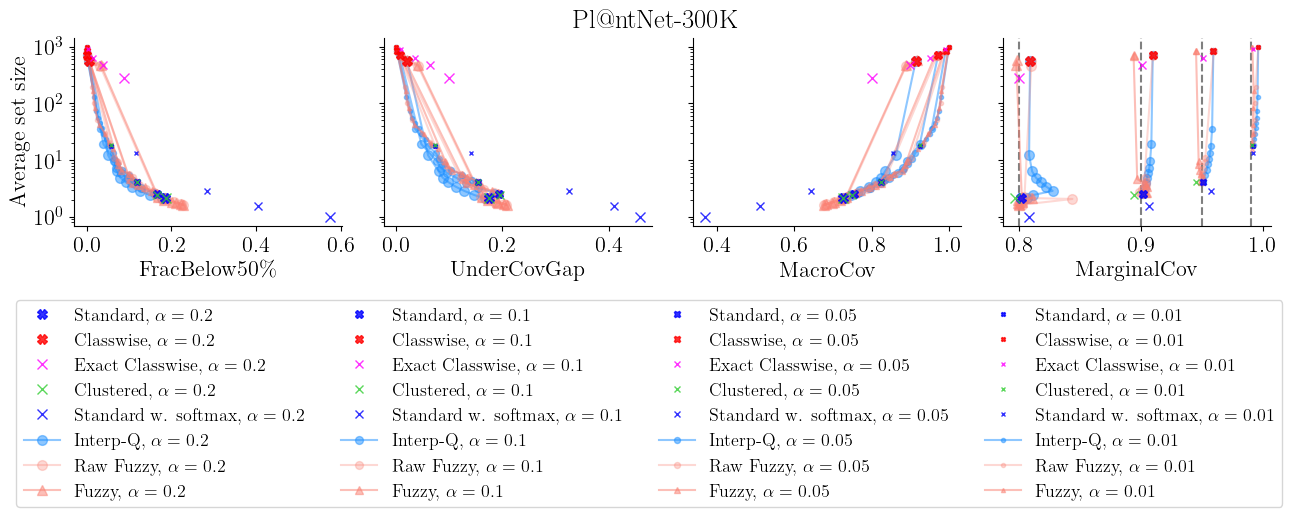

set_size_metric='train_mean'
Saved no-legend version to figs/plantnet-trunc/ALL_metrics_plantnet-trunc_PAS_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


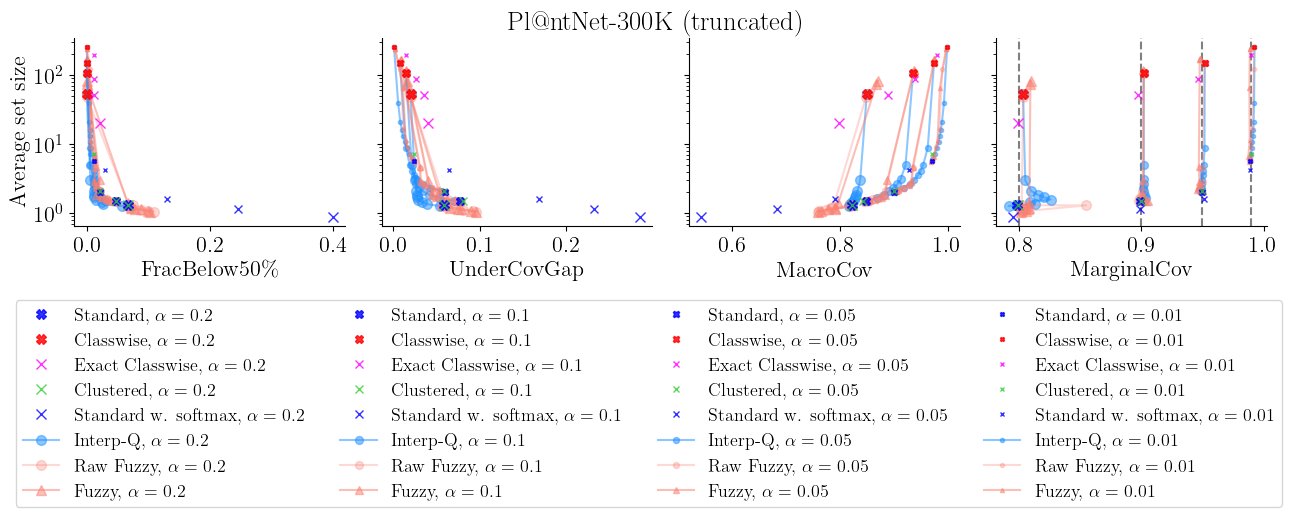

set_size_metric='mean'
Saved no-legend version to figs/inaturalist/ALL_metrics_inaturalist_PAS_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


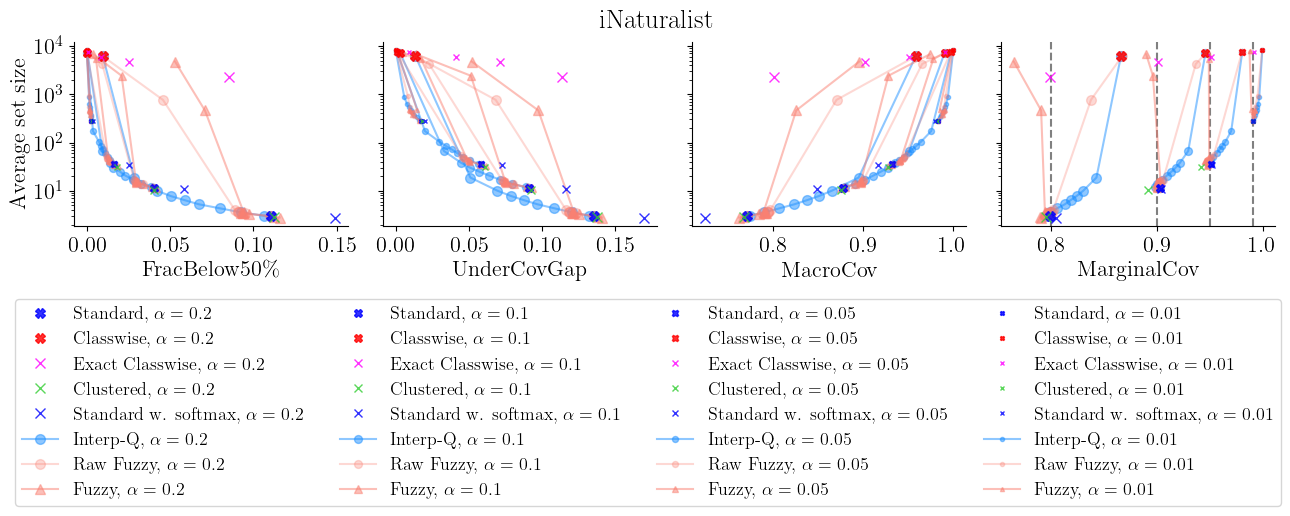

set_size_metric='train_mean'
Saved no-legend version to figs/inaturalist-trunc/ALL_metrics_inaturalist-trunc_PAS_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


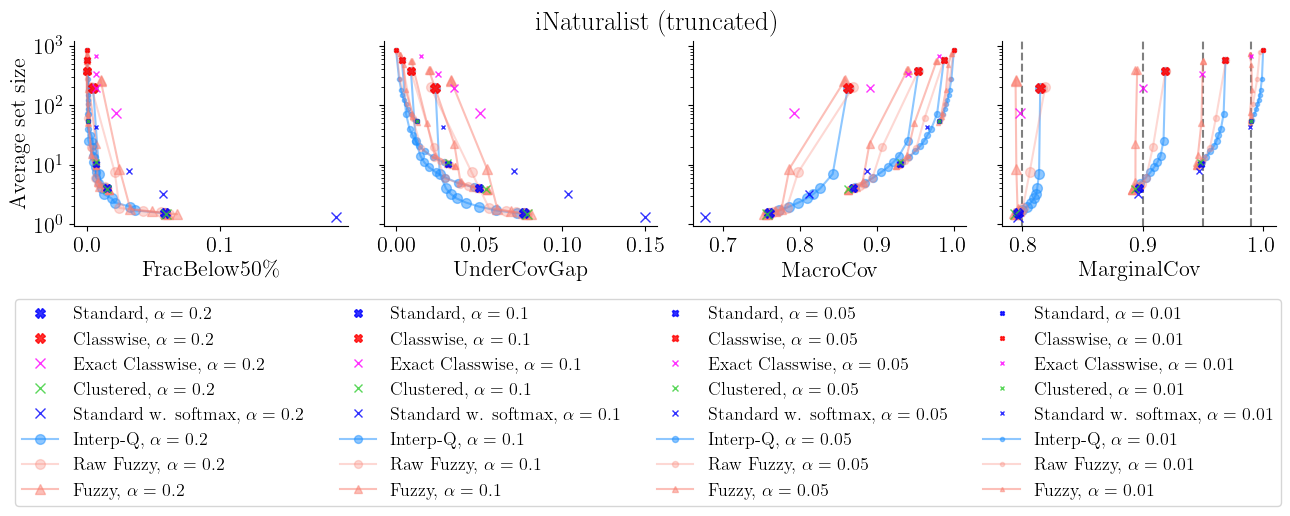

In [5]:
score = 'PAS'
methods = ['standard', 'classwise', 'classwise-exact', 'clustered'] + \
            [f'fuzzy-rarity-{bw}' for bw in rarity_bandwidths] +\
            [f'fuzzy-RErarity-{bw}' for bw in rarity_bandwidths] +\
            [f'cvx-cw_weight={w}' for w in cw_weights] 


for dataset in dataset_names.keys():
    generate_all_pareto_plots(dataset, score, alphas, methods, legendfontsize=13)

### Fuzzy with Random and Quantile projections

set_size_metric='mean'
Saved no-legend version to figs/plantnet/ALL_metrics_plantnet_softmax_extra_projections_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


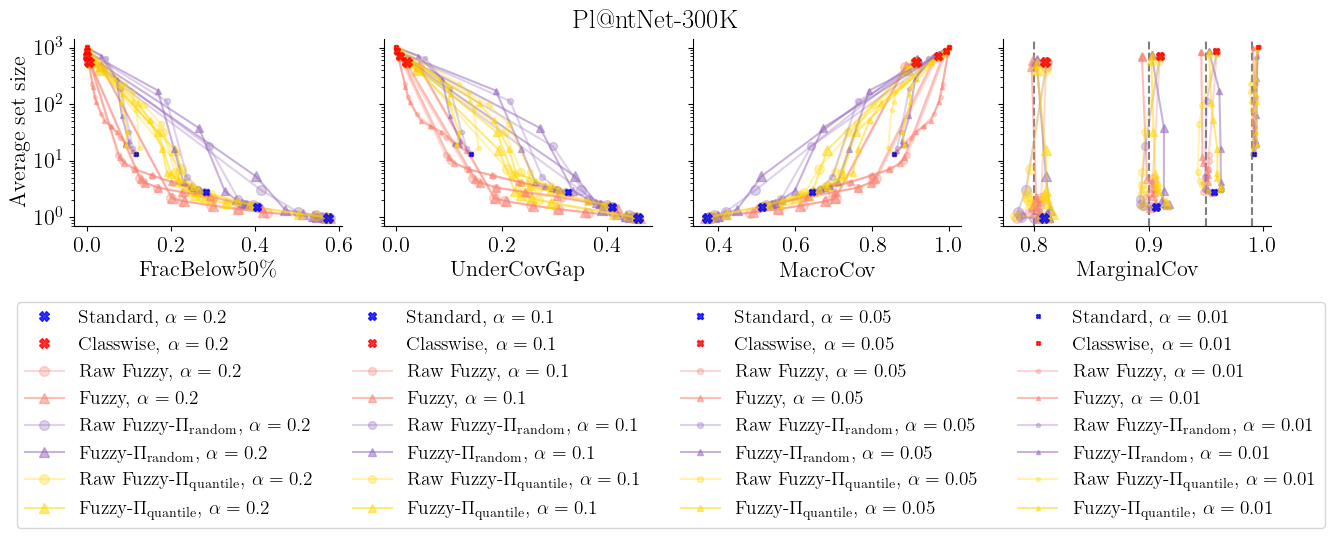

set_size_metric='train_mean'
Saved no-legend version to figs/plantnet-trunc/ALL_metrics_plantnet-trunc_softmax_extra_projections_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


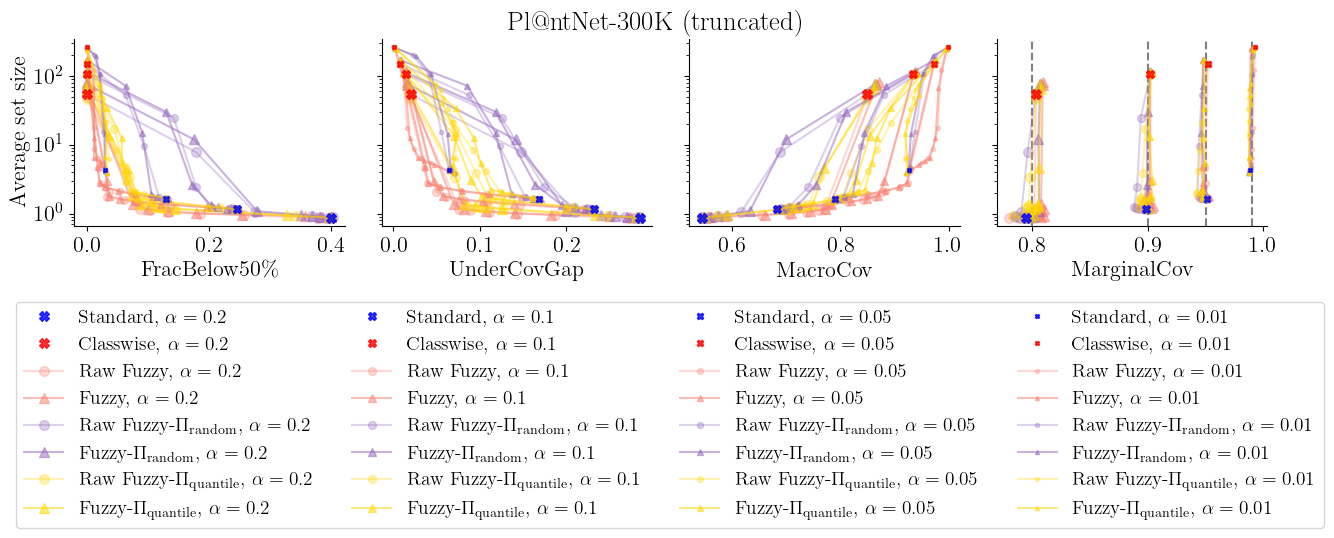

set_size_metric='mean'
Saved no-legend version to figs/inaturalist/ALL_metrics_inaturalist_softmax_extra_projections_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


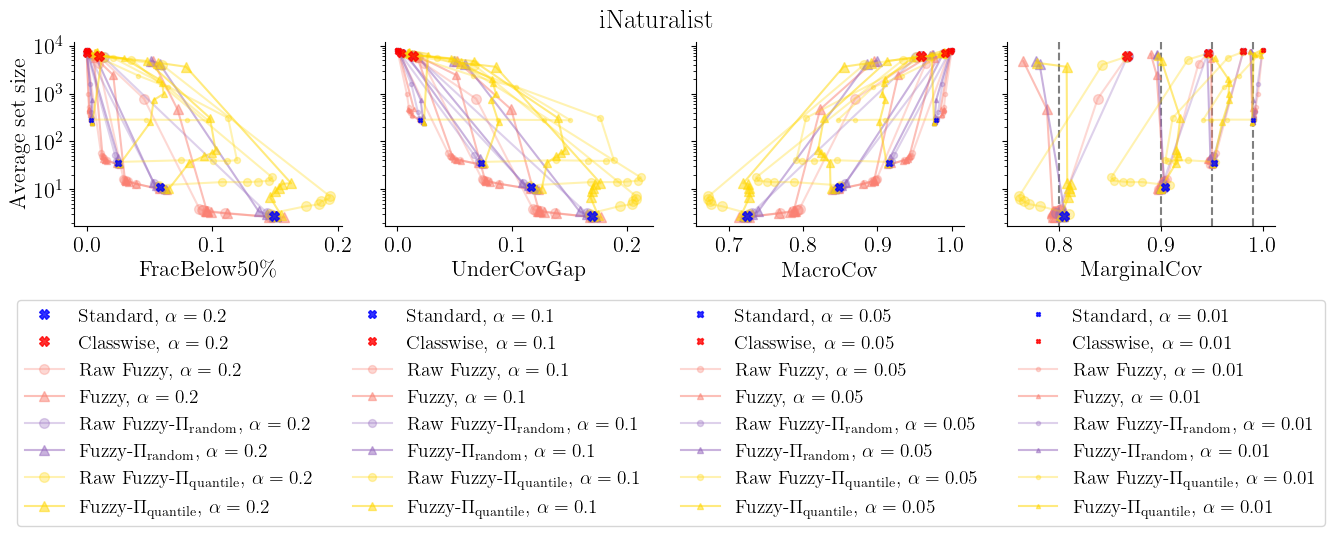

set_size_metric='train_mean'
Saved no-legend version to figs/inaturalist-trunc/ALL_metrics_inaturalist-trunc_softmax_extra_projections_pareto_NO_LEGEND.pdf and version with legend to [...]WITH_LEGEND.pdf and .jpg


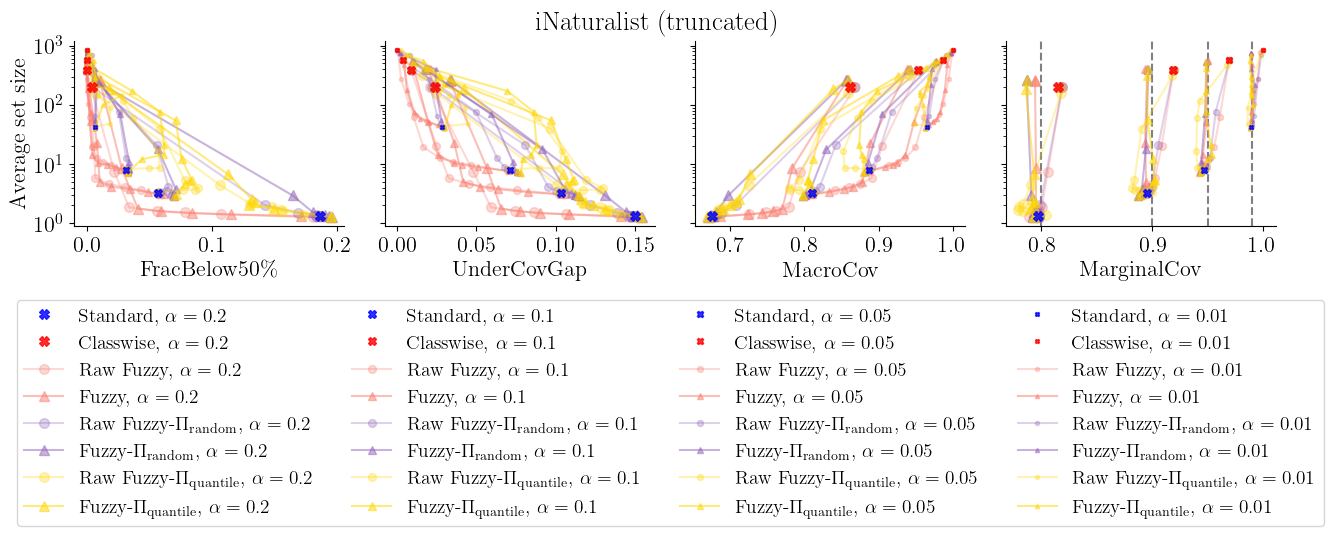

In [6]:
bandwidths = rarity_bandwidths
score = 'softmax'
methods = ['standard', 'classwise'] + \
        [f'fuzzy-rarity-{bw}' for bw in bandwidths] + \
        [f'fuzzy-RErarity-{bw}' for bw in bandwidths] + \
        [f'fuzzy-random-{bw}' for bw in bandwidths] + \
        [f'fuzzy-RErandom-{bw}' for bw in bandwidths] + \
        [f'fuzzy-quantile-{bw}' for bw in bandwidths] + \
        [f'fuzzy-REquantile-{bw}' for bw in bandwidths] 

for dataset in dataset_names.keys():
    generate_all_pareto_plots(dataset, score, alphas, methods, save_suffix='_extra_projections', show_inset=False)

In [7]:
get_inputs_folder()

'train_models/data'